In [6]:

import datetime
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from autots import AutoTS
import pathlib
import json


from scipy.interpolate import griddata as gd

from pykrige.ok import OrdinaryKriging

import matplotlib.animation as animation
from matplotlib import cm

In [2]:
from mpl_toolkits import mplot3d

In [3]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

In [4]:
gelman_data = pd.read_excel("../../result(new)/joined_well_data.xlsx")
gelman_data.head(5)

,Unnamed: 0,Bore,Name,Depth1,Depth2,SampleDate,Value,Comment,Enabled,Easting,...,utm_datum,utm_zone,utm_x,utm_y,utm_unit,pj4_x,pj4_y,pj4_paramstr,lat,lon
0,0,1021 Westview Way,1-4 Dioxane,260.0,268.0,2019-05-08,0.5,EGLE Lab,False,13274717.9,...,22,12,0,0,1,0,0,NaN,42.269732,-83.807344
1,1,1024 Westview Way,1-4 Dioxane,-9999.0,-9999.0,2019-05-08,0.5,EGLE Lab,False,13274221.6,...,22,12,0,0,1,0,0,NaN,42.269808,-83.809177
2,2,1049 Westview Way,1-4 Dioxane,272.0,280.0,2019-05-08,0.5,EGLE Lab,False,13274722.1,...,22,12,0,0,1,0,0,NaN,42.269390,-83.807331
3,3,105 Myrtle,1-4 Dioxane,61.0,65.0,1999-03-27,0.5,NaN,False,13269250.0,...,22,12,0,0,1,0,0,NaN,42.285462,-83.827411
4,4,105 Myrtle,1-4 Dioxane,61.0,65.0,1999-05-28,0.5,NaN,False,13269250.0,...,22,12,0,0,1,0,0,NaN,42.285462,-83.827411


In [49]:
extrapolation_interval = 30

interpolationmethod = 'nearest'

def extract_by_date(start_date = datetime.datetime(1986, 1, 1), end_date = datetime.datetime(1991, 12, 31)):
    zdata = []
    val_data = []
    xdata = []
    ydata = []

    grouped = gelman_data.groupby('Bore')
    count = 0
    for name, group in grouped:
        count += 1

        group.loc[:, 'ds'] = pd.to_datetime(group['SampleDate'])
        tmp = []
        for index, row in group.iterrows():
            ds = row['ds']
            e = row['Easting']
            if start_date <= ds <= end_date and e > 13270000:
                tmp.append(row)
        df = pd.DataFrame(tmp)
        if len(tmp) > 0:
            mean_value = df["Value"].mean()
            xdata.append(pd.to_numeric(df['Easting'],errors ='ignore').iloc[0])
            ydata.append(pd.to_numeric(df['Northing'],errors ='ignore').iloc[0])
            depth = pd.to_numeric(df['Depth1'],errors ='ignore').iloc[0]
            if depth < 0 or depth > 1000:
                depth = 0
            zdata.append(-depth)
            val_data.append(mean_value)
    return xdata, ydata, zdata, val_data

def get_ztop(xdata, ydata, zdata):
    t = []
    for i in range(len(xdata)):
        tmp = [xdata[i], ydata[i], zdata[i]]
        t.append(tmp)
    top = np.asarray(t)
    t.clear()
    return top

def interpolation(d, xrange, yrange):
    grid_x, grid_y = np.mgrid[xrange[0]:xrange[1]:100j, yrange[0]:yrange[1]:100j]
    grid_z = gd(d[:, :2], d[:, 2], (grid_x, grid_y), method=interpolationmethod, rescale=True)
    return grid_x, grid_y, grid_z

def interpolationValue(d, xrange, yrange):
    grid_x, grid_y = np.mgrid[xrange[0]:xrange[1]:100j, yrange[0]:yrange[1]:100j]
    grid_z = gd(d[:, :2], d[:, 2], (grid_x, grid_y), method='cubic')
    return grid_x, grid_y, grid_z

def nearest_neighbor_interpolation(data, x, y, p=0.5):
    """
    Nearest Neighbor Weighted Interpolation
    http://paulbourke.net/miscellaneous/interpolation/
    http://en.wikipedia.org/wiki/Inverse_distance_weighting

    :param data: numpy.ndarray
        [[float, float, float], ...]
    :param p: float=0.5
        importance of distant samples
    :return: interpolated data
    """
    n = len(data)
    vals = np.zeros((n, 2), dtype=np.float64)
    distance = lambda x1, x2, y1, y2: (x2 - x1)**2 + (y2 - y1)**2
    for i in range(n):
        vals[i, 0] = data[i, 2] / (distance(data[i, 0], x, data[i, 1], y))**p
        vals[i, 1] = 1          / (distance(data[i, 0], x, data[i, 1], y))**p
    z = np.sum(vals[:, 0]) / np.sum(vals[:, 1])
    return z

def extrapolation(data, extrapolation_spots,  xrange, yrange,method='nearest'):
    if method == 'kriging':
        xx, yy, zz, ss = kriging(data, xrange, yrange)

        new_points = np.zeros((len(yy) * len(zz), 3))
        count = 0
        for i in range(len(xx)):
            for j in range(len(yy)):
                new_points[count, 0] = xx[i]
                new_points[count, 1] = yy[j]
                new_points[count, 2] = zz[i, j]
                count += 1
        combined = np.concatenate((data, new_points))
        return combined

    if method == 'nearest':
        new_points = np.zeros((len(extrapolation_spots), 3))
        new_points[:, 0] = extrapolation_spots[:, 0]
        new_points[:, 1] = extrapolation_spots[:, 1]
        for i in range(len(extrapolation_spots)):
            new_points[i, 2] = nearest_neighbor_interpolation(data,
                                    extrapolation_spots[i, 0],
                                    extrapolation_spots[i, 1], p=4)
        combined = np.concatenate((data, new_points))
        return combined

def kriging(k_data, xrange, yrange):
    # 13270000.0 - 13290000.0
    # grid_x = np.arange(xrange[0], xrange[1], 500)
    # 283000.0 - 287000.0
    # grid_y = np.arange(yrange[0], yrange[1], 200)

    grid_x = np.arange(xrange[0], xrange[1], 1000)

    grid_y = np.arange(yrange[0], yrange[1], 500)
    OK = OrdinaryKriging(k_data[:, 0], k_data[:, 1], k_data[:, 2], variogram_model='linear',
                                 verbose=False)

    z_res, ss = OK.execute('grid', grid_x, grid_y)
    return grid_x, grid_y, z_res, ss

def kriging_analysis(extrapolation_spots_t, top, value_top, scatter, debug, xrange, yrange):
    top_extra = extrapolation(top, extrapolation_spots_t,  xrange, yrange, method='kriging')

    print(top_extra)

    gridx_top, gridy_top, gridz_top = interpolation(top_extra, xrange, yrange)

    print(type(gridz_top))

    print(gridz_top)

    top_value_extra = extrapolation(value_top, extrapolation_spots_t, xrange, yrange, method='nearest')
    gridx_v_top, gridy_v_top, gridz_v_top = interpolationValue(top_value_extra, xrange, yrange)
    # gridz_v_top = gridz_top

    plot(top, gridx_top, gridy_top, gridz_top, gridz_v_top ,method='snaps',
            title='_top_kriging', scatter = scatter, debug = debug)

def plot(data, gridx, gridy, gridz, grid_value_z, method='rotate', title='nearest', both=False,
         scatter = True, debug = False):
    fig = plt.figure(figsize=(10, 10))
    angles = [45, 120, 220, 310]

    for i in range(1, 2):
        ax = fig.add_subplot(2, 2, i, projection='3d')
        gridz_ = np.nan_to_num(gridz)

        grid_value_z = np.nan_to_num(grid_value_z)

        if debug:
            print(grid_value_z)
            print(grid_value_z.min())
            print(grid_value_z.max())

        bounds = [grid_value_z.min(), 0,4,
                  7.2,85,
                  150,280,500,
                  1000,1900,3000,5000, grid_value_z.max()]
        norm = matplotlib.colors.BoundaryNorm(boundaries=bounds, ncolors=256)
        # norm = matplotlib.colors.LogNorm(grid_value_z.min(), grid_value_z.max())
        colors = cm.viridis(norm(grid_value_z))
        rcount, ccount, _ = colors.shape


        ax.plot_surface(gridx, gridy, gridz_,
                   rcount=rcount, ccount=ccount,
                       facecolors=colors, shade=False, alpha = 0.5)

        # ax.plot_wireframe(gridx, gridy, gridz_, alpha=0.5)

        if scatter:
            ax.scatter(data[:, 0], data[:, 1], data[:, 2], c='red')
        ax.view_init(azim=angles[i])

    plt.savefig('snaps_{}.png'.format(title))

def get_plane(xl, xu, yl, yu, i):
    xx = np.arange(xl, xu, i)
    yy = np.arange(yl, yu, i)
    extrapolation_spots_res = np.zeros((len(xx) * len(yy), 2))
    count = 0
    for i in xx:
        for j in yy:
            extrapolation_spots_res[count, 0] = i
            extrapolation_spots_res[count, 1] = j
            count += 1
    return extrapolation_spots_res

def main(start_date = datetime.datetime(1986, 1, 1), end_date = datetime.datetime(1991, 12, 31),
         xrange = (13270000.0, 13280000.0),
         yrange = (283000.0, 287000.0),
         scatter = True, debug = False):
    xdata,ydata,zdata,val_data = extract_by_date(start_date, end_date)
    zdata.sort()
    print(zdata)
    extrapolation_spots = get_plane(xrange[0], xrange[1], yrange[0], yrange[1], extrapolation_interval)

    top = get_ztop(xdata, ydata, zdata)
    value_top = get_ztop(xdata, ydata, val_data)

    kriging_analysis(extrapolation_spots, top, value_top, scatter, debug, xrange, yrange)

[-276.5, -272.0, -268.0, -268.0, -260.0, -258.0, -252.0, -249.0, -247.0, -246.0, -243.0, -242.0, -240.0, -236.0, -235.0, -229.0, -227.0, -226.0, -225.0, -224.0, -222.0, -218.0, -215.0, -214.0, -214.0, -211.0, -210.0, -210.0, -206.0, -205.0, -202.0, -201.0, -201.0, -200.0, -200.0, -200.0, -197.0, -195.0, -195.0, -195.0, -195.0, -195.0, -194.0, -194.0, -194.0, -193.0, -190.0, -190.0, -188.0, -187.0, -186.0, -186.0, -185.0, -185.0, -181.0, -181.0, -180.0, -180.0, -180.0, -180.0, -178.0, -178.0, -177.0, -177.0, -175.0, -175.0, -175.0, -175.0, -175.0, -173.0, -170.0, -170.0, -170.0, -169.0, -169.0, -168.0, -167.0, -166.0, -165.0, -165.0, -165.0, -165.0, -164.0, -162.0, -161.0, -161.0, -160.0, -160.0, -160.0, -159.0, -159.0, -158.0, -158.0, -155.0, -155.0, -155.0, -155.0, -153.0, -153.0, -153.0, -152.0, -152.0, -152.0, -152.0, -151.0, -150.0, -150.0, -150.0, -150.0, -149.0, -148.0, -148.0, -148.0, -146.0, -145.0, -145.0, -145.0, -142.0, -142.0, -142.0, -141.0, -140.0, -140.0, -140.0, -140.0,

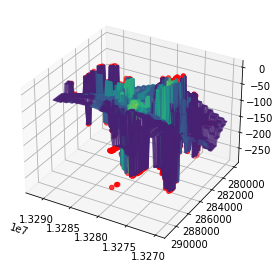

In [50]:
main(datetime.datetime(2016, 1, 1), datetime.datetime(2021, 12, 31), xrange = (13270000.0, 13290000.0),
         yrange = (280000.0, 290000.0), scatter = True, debug = False)